### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/3_KerasApplicationsTesting

Mounted at /gdrive
/gdrive/My Drive/Progetto AN2DL/FeatureExtractorTesting


### Import libraries

In [ ]:
# Hide warnings
seed  = 42
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

### Load and process the dataset

In [ ]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save labels in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [ ]:
# Number of images to display
num_img = 100

# Create subplots for displaying images
fig, axes = plt.subplots(10, num_img//10, figsize=(20, 20))
for i in range(num_img):
    ax = axes[i%10, i%num_img//10]
    ax.imshow(np.clip(images[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.1,
    stratify=labels
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4503, 96, 96, 3), y_train shape: (4503, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


### ResNet152V2

In [ ]:
# Import Feature Extractor with specified settings
feature_extractor = tfk.applications.ResNet152V2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

234545216/234545216 [==============================] - 1s 0us/step


### Model

In [ ]:
# Define network parameters/callbacks
dropout_rate = 1/10
learning_rate = 1e-3

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [ ]:
def build_model(feature_extractor, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=64, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=64, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 HiddenDense1 (Dense)        (None, 64)                131136    
                                                                 
 HiddenActivation1 (Activat  (None, 64)                0         
 ion)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 HiddenDense2 (Dense)        (None, 64)                4160      
                                                             

In [ ]:
# Train the model
history = model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 36s 67ms/step - loss: 0.5599 - accuracy: 0.7215 - val_loss: 0.4911 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 15s 54ms/step - loss: 0.4520 - accuracy: 0.7870 - val_loss: 0.4639 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 16s 55ms/step - loss: 0.3856 - accuracy: 0.8283 - val_loss: 0.4713 - val_accuracy: 0.8024 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 13s 47ms/step - loss: 0.3260 - accuracy: 0.8579 - val_loss: 0.5032 - val_accuracy: 0.7884 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 14s 51ms/step - loss: 0.2596 - accuracy: 0.8912 - val_loss: 0.5323 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 13s 47ms/step - loss: 0.1987 - accuracy: 0.9181 - val_loss: 0.5611 - val_accuracy: 0.7904 - lr: 0.0010
Epoch 7/200
282/282 [==============================]

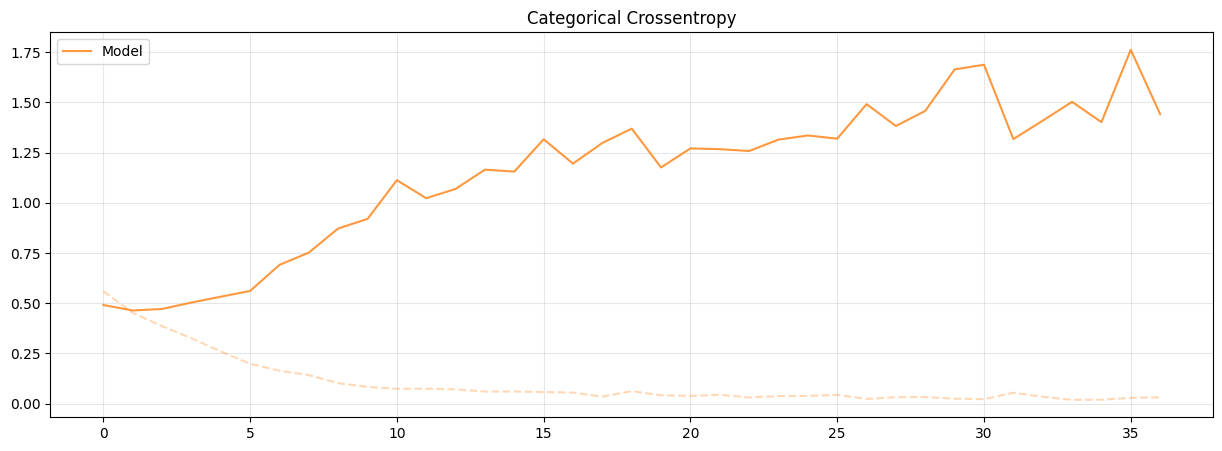

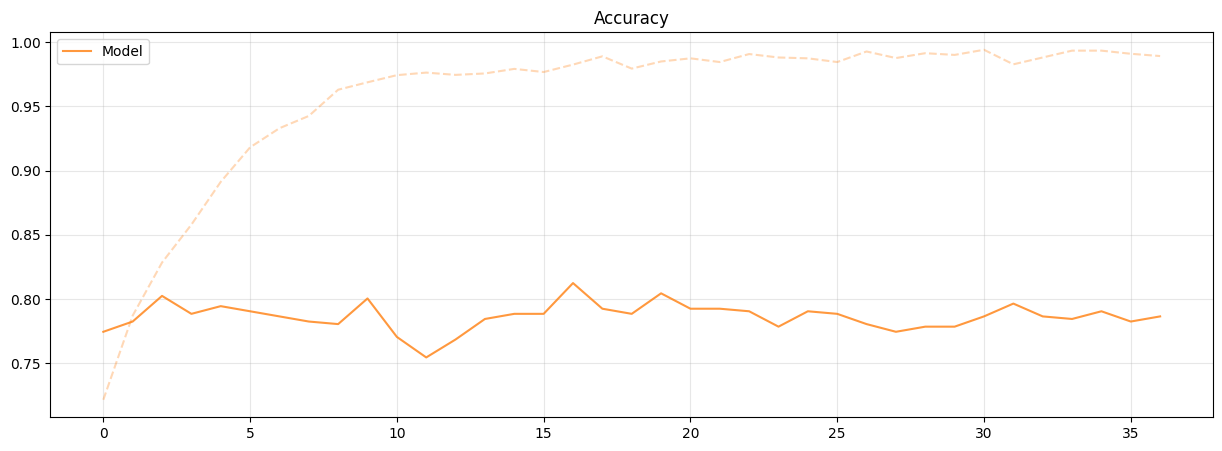

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Model', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Model', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('ResNet152V2')